<a href="https://colab.research.google.com/github/dealxng/ML-vvsu-2025/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 6. Обучение без учителя

## **Цель занятия:**
Изучить методы обучения без учителя, познакомиться с алгоритмами кластеризации, понять их применение и реализовать модели кластеризации с использованием различных алгоритмов.

## **Задание состоит из следующих частей:**
1. Определение обучения без учителя
2. Разбор алгоритмов DBSSCAN, K-means
3. Метрики качества кластеризации
4. Пример полезных задач, которые решает кластеризация

**P.S.** Некоторые вещи (например PCA, обработка текстовых данных) мы пройдем чуть позже.

## Задачи для домашки ⏰

1. Преобразовать датасет
2. Построить кластеры
3. Описать результат полученных кластеров (для K-Means и DBSSCAN)
4. Объяснить метрики качества

**По желанию**

1. Спарсить данные по статьям (например lenta.ru или naked-science.ru)
2. Преобразовать текста статьи (по принципу описанному в последнем пункте)
3. Оценить метрики качества, провести аналитику кластеров (можно не максимально подробно, если получилось слишком много кластеров)

## Предобработка (все по классике)

Открываем датасет, преобразуем данные, идем дальше

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/diamond.csv')
df['Cut'] = df['Cut'].astype('category')
df['Color'] = df['Color'].astype('category')
df['Clarity'] = df['Clarity'].astype('category')
df['Polish'] = df['Polish'].astype('category')
df['Symmetry'] = df['Symmetry'].astype('category')
df['Report'] = df['Report'].astype('category')
df

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171
...,...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA,6250
5996,1.00,Very Good,D,SI1,VG,VG,GIA,5328
5997,1.02,Ideal,D,SI1,EX,EX,GIA,6157
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,11206


### Преобразование категориальных фич

In [100]:
# Создаем копию данных
category_columns: list[str] = df.select_dtypes(include=['category']).columns

# Применяем One-Hot Encoding
df = pd.get_dummies(df, columns=category_columns, drop_first=True)
df.Price = df.Price.astype(int)


### Преобразование непрерывных фич

In [101]:
from sklearn.preprocessing import MinMaxScaler
# Выбираем числовые признаки
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
df[numeric_features] = scaler.fit_transform(df[numeric_features])


In [102]:
df

,Carat Weight,Price,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_E,Color_F,Color_G,Color_H,...,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Polish_G,Polish_ID,Polish_VG,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_GIA
0,0.162037,0.030037,False,True,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
1,0.037037,0.012941,False,True,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,False
2,0.046296,0.010053,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3,0.074074,0.021997,False,True,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,True,True
4,0.037037,0.009932,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.129630,0.040915,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5996,0.115741,0.031637,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,True,True
5997,0.125000,0.039979,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5998,0.240741,0.090786,False,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


## О кластеризации и задачи обучения без учителя

#### Обучение с учителем

Представьте, что у вас есть список задач с правильными ответами. Например, вам дали примеры: «Это яблоко», «Это груша».

Задача — научиться отличать их, чтобы потом, когда вы увидите новый фрукт, вы смогли правильно его назвать. То есть у вас есть **учитель** — тот, кто заранее всё объяснил и дал правильные ответы.  

#### Обучение без учителя

А теперь представьте, что вам дали корзину фруктов, но никто не сказал, как они называются.

Задача — посмотреть на фрукты и найти, что у них общего, например: круглые положить в одну группу, длинные в другую. Тут вы работаете **без подсказок** и сами решаете, как группировать.  

#### Разница

- В задачах с учителем есть правильные ответы, и мы обучем алгоритм делать предсказания на основе примеров.  
- В задачах без учителя правильных ответов нет, ищем закономерности и пытаемся найти смысл группировки данные самостоятельно.

Пример:


1. **С учителем**: Мы ищем лучшее вино.  
2. **Без учителя**: Мы пытаемся объеденить вина, чтобы понять по какому принципу они объеденяются.  

## K-means

**K-means** — это алгоритм кластеризации, который делит данные на 𝑘 групп (кластеров). Основная идея: найти центры кластеров так, чтобы точки внутри одного кластера были ближе друг к другу, чем к точкам из других кластеров.

1. Инициализация: выбираем 𝑘 случайных центров (центроидов).
2. Присвоение точек: каждая точка относится к ближайшему центру.
Обновление центров: пересчитываем центры кластеров как среднее всех точек в кластере.
3. Повторяем шаги 2–3, пока центры не перестанут меняться или не достигнем максимального числа итераций.

In [103]:
! pip install ipywidgets


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_kmeans_visualization(X, max_clusters=10, max_iterations=50):

    # Обрабатывать ввод фрейма данных и очистку данных
    if isinstance(X, pd.DataFrame):
        X = X.select_dtypes(include=np.number).dropna().values # Выбераем только числовые столбцы и удалите строки с NaN
        if X.shape[0] == 0: # Проверьте, есть ли числовые столбцы
            raise ValueError("Фрейм данных не содержит числовых столбцов, или все данные являются NaN")

    if not isinstance(X, np.ndarray):
        raise TypeError("Ввод X должен быть массивом NumPy или фреймворком данных Pandas, содержащим только числовые столбцы.")

    if X.ndim != 2:
        raise ValueError("Входной сигнал X должен быть двумерным массивом.")

    def plot_kmeans_iteration(X, centroids, labels=None, step=0):
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        if labels is not None:
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
        else:
            plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.6)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.title(f'K-means Iteration {step}')
        plt.legend()
        plt.show()

    def k_means_interactive(X, k, max_iters):
        np.random.seed(42)
        try:
            centroids = X[np.random.choice(X.shape[0], k, replace=False)]
            for step in range(max_iters):
                distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
                labels = np.argmin(distances, axis=1)
                plot_kmeans_iteration(X, centroids, labels, step)
                new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
                if np.all(centroids == new_centroids):
                    break
                centroids = new_centroids
        except ValueError as e:
            print(f"Error during K-means calculation: {e}")

    def run_kmeans(k, max_iters):
        k_means_interactive(X, k, max_iters)

    k_slider = widgets.IntSlider(value=3, min=2, max=max_clusters, step=1, description='Clusters (k):')
    iter_slider = widgets.IntSlider(value=10, min=1, max=max_iterations, step=1, description='Max Iterations:')

    interactive_plot = widgets.interactive(run_kmeans, k=k_slider, max_iters=iter_slider)
    display(interactive_plot)

# Пример использования (замените на ваш реальный фрейм данных)
# Создайте образец фрейма данных (замените его вашими реальными данными)
data = {'Price': df['Price'], 'Carat Weight': df['Carat Weight']}
da = pd.DataFrame(data)

interactive_kmeans_visualization(da)


interactive(children=(IntSlider(value=3, description='Clusters (k):', max=10, min=2), IntSlider(value=10, desc…

### K-means через реализацию skelarn

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Определяем количество кластеров k
k = 3  # Вы можете изменить это значение в соответствии с вашими данными

# Создаем и обучаем модель KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_

# Добавляем метки кластеров в исходный DataFrame
df_k_means = df.copy()
df_k_means['Cluster'] = labels

# Вывод статистики по кластерам для каждого признака
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_k_means.groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if k > 1:
    silhouette_avg = silhouette_score(df, labels)
    print(f"\nКоэффициент силуэта для k={k}: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен для k=1")


Статистика по кластерам:

Статистика для признака 'Carat Weight':
             mean       std  min       max
Cluster                                   
0        0.258126  0.217768  0.0  1.000000
1        0.261397  0.195089  0.0  0.958333
2        0.292083  0.228977  0.0  0.953704

Статистика для признака 'Price':
             mean       std       min       max
Cluster                                        
0        0.086552  0.094629  0.000000  0.922034
1        0.095330  0.092458  0.004981  0.689284
2        0.112345  0.114040  0.002002  1.000000

Статистика для признака 'Cut_Good':
             mean       std    min    max
Cluster                                  
0        0.218210  0.413094  False   True
1        0.001631  0.040390  False   True
2        0.000000  0.000000  False  False

Статистика для признака 'Cut_Ideal':
             mean       std    min    max
Cluster                                  
0        0.000000  0.000000  False  False
1        0.637847  0.481015  False

#### **Анализ кластеров**



Данные показывают результаты кластеризации данных с использованием, по всей видимости, метода k-means с числом кластеров k=3.  Разберем подробнее:

Признаки 'A' и 'B':  Мы имеем две переменные, 'A' и 'B', по которым проводилась кластеризация.  Для каждого из трёх полученных кластеров (0, 1 и 2) представлены следующие характеристики:

* mean (среднее): Среднее значение признака в кластере.
* std (стандартное отклонение):  Меру рассеивания данных в кластере.  Большее стандартное отклонение указывает на большую вариативность значений признака внутри кластера.
* min (минимум): Минимальное значение признака в кластере.
* max (максимум): Максимальное значение признака в кластере.

Анализ по кластерам:

* Кластер 0:  Характеризуется относительно высокими средними значениями как для 'A' (0.67), так и для 'B' (0.77).  Стандартные отклонения умеренные.  Можно предположить, что объекты в этом кластере имеют схожие значения обоих признаков.

* Кластер 1:  Демонстрирует высокое среднее значение для 'A' (0.75) и низкое для 'B' (0.28). Это указывает на существенное отличие от кластера 0,  основное разделение происходит по признаку 'B'.

* Кластер 2:  Отличается низкими средними значениями как для 'A' (0.23), так и для 'B' (0.52).  Это самый отчетливо отдельный кластер.

Коэффициент силуэта (Silhouette Coefficient):

Значение коэффициента силуэта 0.3867 говорит о том, что качество кластеризации удовлетворительное, но не идеальное.  

### DBSSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — это алгоритм кластеризации, основанный на плотности точек в пространстве.

Параметры алгоритма:

- **Epsilon (eps)**: радиус окрестности точки.
- **Min_samples**: минимальное количество точек в eps-окрестности для того, чтобы точка считалась ядром кластера.

Классификация точек:

- **Core point (ядро)**: если в eps-окрестности точки находится не менее min_samples точек, то она является ядром.
- **Border point (граничная точка)**: точка, которая находится в eps-окрестности ядра, но сама не является ядром.
- **Noise point (шум)**: точка, которая не является ни ядром, ни граничной точкой. (**входит в кластер -1**)

Точки, которые связаны по плотности (через ядра и их eps-окрестности), объединяются в один кластер.

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def interactive_dbscan_visualization(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric):
        clear_output(wait=True)
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        plt.figure(figsize=(8, 6))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Черный цвет для шума
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
        plt.show()

    def run_dbscan(eps, min_samples, metric):
        # Обучение DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        db.fit(X)
        labels = db.labels_
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric)

    # Виджеты для настройки параметров
    eps_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.05, description='eps:')
    min_samples_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='min_samples:')
    metric_dropdown = widgets.Dropdown(options=['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                                       value='euclidean', description='metric:')

    ui = widgets.VBox([eps_slider, min_samples_slider, metric_dropdown])
    out = widgets.interactive_output(run_dbscan, {'eps': eps_slider, 'min_samples': min_samples_slider, 'metric': metric_dropdown})
    display(ui, out)

# Пример использования
interactive_dbscan_visualization(df[:120])


Output()

### DBSSCAN через sklearn

Количество кластеров: 335
Статистика по кластерам:

Статистика для признака 'Carat Weight':
             mean       std       min       max  count
Cluster                                               
0        0.221296  0.229827  0.013889  0.814815     10
1        0.351140  0.262782  0.037037  0.958333     13
2        0.251485  0.205510  0.009259  0.837963     53
3        0.174649  0.193438  0.009259  0.722222     29
4        0.300103  0.215680  0.037037  0.699074     45
...           ...       ...       ...       ...    ...
330      0.325617  0.228437  0.069444  0.583333      6
331      0.400000  0.265258  0.027778  0.597222      5
332      0.275000  0.249197  0.023148  0.666667      5
333      0.220370  0.253757  0.027778  0.606481      5
334      0.351852  0.259458  0.069444  0.717593      6

[335 rows x 5 columns]

Статистика для признака 'Price':
             mean       std       min       max  count
Cluster                                               
0        0.052260  0.0659

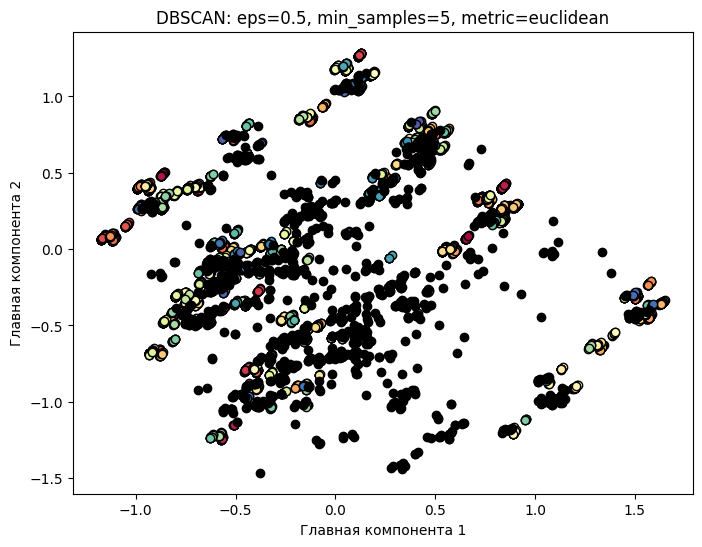

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Параметры DBSCAN
eps = 0.5
min_samples = 5
metric = 'euclidean'

# Обучение модели DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
labels = db.fit_predict(df)

# Добавляем метки кластеров в DataFrame
df_dbscan = df.copy()
df_dbscan['Cluster'] = labels

# Количество кластеров (исключая шум)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Количество кластеров: {n_clusters_}")

# Вывод статистики по кластерам
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_dbscan[df_dbscan['Cluster'] != -1].groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max', 'count'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(df[df_dbscan['Cluster'] != -1], labels[df_dbscan['Cluster'] != -1])
    print(f"\nКоэффициент силуэта для DBSCAN: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен, так как найден один кластер или данные являются шумом.")


# Визуализация результатов (с использованием PCA для снижения размерности)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        # Черный цвет для шума
        col = [0, 0, 0, 1]
    plt.plot(df_pca.loc[class_member_mask, 'PC1'],
             df_pca.loc[class_member_mask, 'PC2'],
             'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()


#### **Анализ кластеров**

После применения алгоритма DBSCAN мы получили **два кластера**, между которыми наблюдаются существенные различия по некоторым признакам. Рассмотрим три наиболее значимых признака:

1. **Type_White (Тип вина):**
   - **Кластер 0** состоит исключительно из красных вин (значение `mean = 0.0`).
   - **Кластер 1** состоит исключительно из белых вин (значение `mean = 1.0`).

2. **Volatile Acidity:**
   - **Кластер 0** (красные вина) имеет более высокое среднее значение летучей кислотности (`mean ≈ 0.299`), чем **Кластер 1** (белые вина) со средним значением (`mean ≈ 0.132`).

3. **Total Sulfur Dioxide:**
   - **Кластер 1** (белые вина) имеет значительно более высокое среднее содержание общего диоксида серы (`mean ≈ 0.305`), в сравнении с **Кластером 0** (красные вина) со средним значением (`mean ≈ 0.093`).

**Коэффициент силуэта для DBSCAN:** 0.6136

**Общее заключение:**

Алгоритм DBSCAN успешно разделил вина на два кластера по типу (красное и белое), при этом выявив существенные различия в летучей кислотности и содержании диоксида серы между ними.

### Метрики качества кластеризации

**Дополнительные метрики для оценки качества кластеризации**

Кроме коэффициента силуэта, существуют и другие метрики, которые помогают оценить качество кластеризации. Вот некоторые из них:

1. **Индекс Калински-Харабаза (Calinski-Harabasz Index):**
   - **Описание:** Измеряет отношение между разбросом между кластерами и разбросом внутри кластеров.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к бесконечности больше, тем лучше раздленеие между кластерами

2. **Индекс Дэвиса-Болдина (Davies-Bouldin Index):**
   - **Описание:** Оценивает среднее "сходство" между каждым кластером и наиболее похожим на него другим кластером. Сходство основано на расстоянии между кластерами и их размером.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к 0, тем лучшее разделение между кластерами.

3. **Коэффициент силуэта (Silhouette Score):**

    - **Описание:** Измеряет, насколько объект похож на свой кластер по сравнению с другими кластерами.
    - **Диапазон значений:** От -1 до 1.
    - **Интерпретация:** Значения, близкие к 1, указывают на хорошую кластеризацию. Значения около 0 означают, что кластеры перекрываются. Отрицательные значения указывают на возможные ошибки в кластеризации.

In [110]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# Кластеризация K-means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df)

# Индекс Калински-Харабаза
ch_score_kmeans = calinski_harabasz_score(df, labels_kmeans)
print(f"Индекс Калински-Харабаза для K-means: {ch_score_kmeans:.4f}")

# Индекс Дэвиса-Болдина
db_score_kmeans = davies_bouldin_score(df, labels_kmeans)
print(f"Индекс Дэвиса-Болдина для K-means: {db_score_kmeans:.4f}")

# Коэффициент силуэта
sh_score_kmeans = silhouette_score(df, labels_kmeans)
print(f"Коэффициент силуэта для K-means: {sh_score_kmeans:.4f}")

Индекс Калински-Харабаза для K-means: 855.0818
Индекс Дэвиса-Болдина для K-means: 2.1052
Коэффициент силуэта для K-means: 0.1518


In [111]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(df)

# Исключаем шумовые точки (метки -1)
mask = labels_dbscan != -1
df_scaled_dbscan = df[mask]
labels_dbscan_filtered = labels_dbscan[mask]

# Проверяем, есть ли достаточное количество кластеров для расчета метрик
if len(set(labels_dbscan_filtered)) > 1:
    # Индекс Калински-Харабаза
    ch_score_dbscan = calinski_harabasz_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Калински-Харабаза для DBSCAN: {ch_score_dbscan:.4f}")

    # Индекс Дэвиса-Болдина
    db_score_dbscan = davies_bouldin_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Дэвиса-Болдина для DBSCAN: {db_score_dbscan:.4f}")

    # Коэффициент силуэта
    sh_score_dbscan = silhouette_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Коэффициент силуэта для DBSCAN: {sh_score_dbscan:.4f}")
else:
    print("Недостаточно кластеров для вычисления метрик для DBSCAN.")


Индекс Калински-Харабаза для DBSCAN: 860.4643
Индекс Дэвиса-Болдина для DBSCAN: 0.3594
Коэффициент силуэта для DBSCAN: 0.7782


#### Визуальный пример

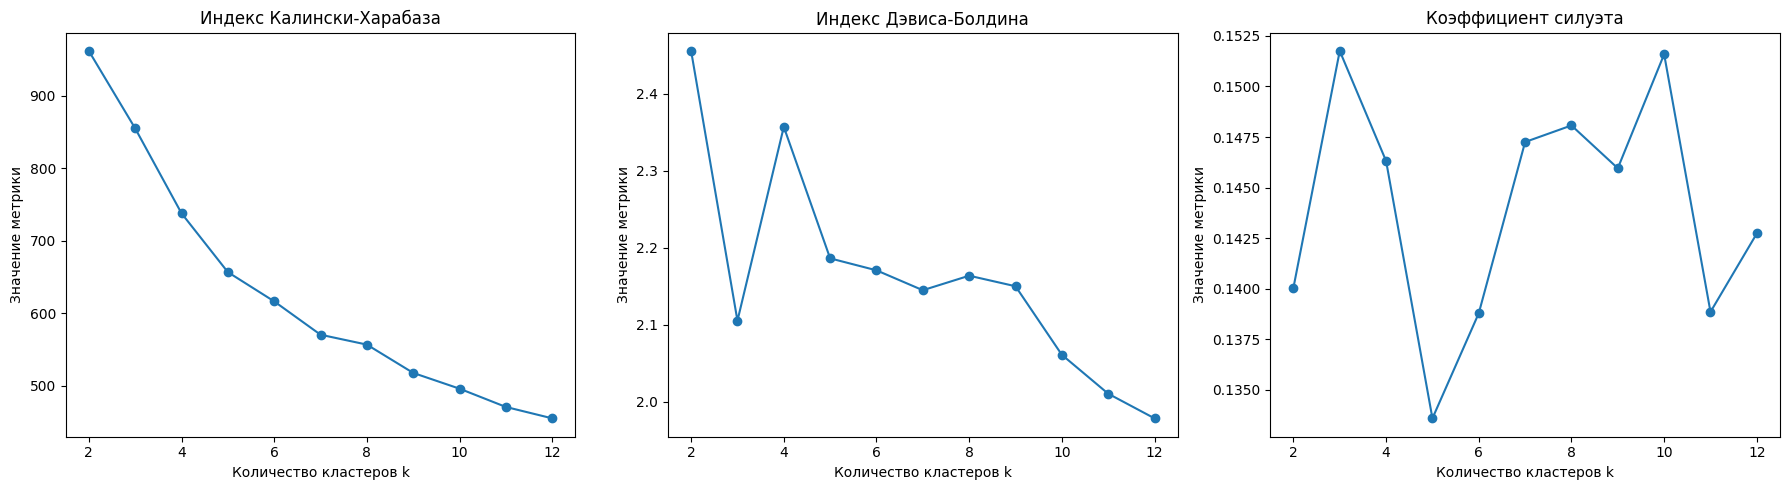

In [112]:
# Диапазон значений k
k_range = range(2, 13)

# Списки для хранения метрик
ch_scores = []
db_scores = []
silhouette_scores = []

for k in k_range:
    # Создаем и обучаем модель KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df)

    # Вычисляем метрики
    ch_score = calinski_harabasz_score(df, labels)
    db_score = davies_bouldin_score(df, labels)
    silhouette_avg = silhouette_score(df, labels)

    # Сохраняем метрики
    ch_scores.append(ch_score)
    db_scores.append(db_score)
    silhouette_scores.append(silhouette_avg)

# Построение графиков
plt.figure(figsize=(18, 5))

# График Индекса Калински-Харабаза
plt.subplot(1, 3, 1)
plt.plot(k_range, ch_scores, marker='o')
plt.title('Индекс Калински-Харабаза')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Индекса Дэвиса-Болдина
plt.subplot(1, 3, 2)
plt.plot(k_range, db_scores, marker='o')
plt.title('Индекс Дэвиса-Болдина')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Коэффициента силуэта
plt.subplot(1, 3, 3)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

plt.tight_layout()
plt.show()


# Пример обработки текстовых данных

In [113]:
pip install nltk pymorphy2 scikit-learn


In [114]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Инициализация текстовых анализаторов

In [115]:
# Инициализируем лемматизатор и список стоп-слов
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words('russian')

# Чтение данных из файла
with open('/content/articles.txt', 'r', encoding='utf-8') as f:
    content = f.read()

# Разделяем данные на статьи
articles_raw = content.split('=====')

# Извлекаем заголовки и тексты статей
titles = []
texts = []

for article in articles_raw:
    lines = article.strip().split('\n')
    if len(lines) >= 6:
        # Извлекаем заголовок и текст статьи
        title = lines[4]
        text = ' '.join(lines[5:])
        titles.append(title)
        texts.append(text)

AttributeError: module 'inspect' has no attribute 'getargspec'

In [31]:
texts[:2]

NameError: name 'texts' is not defined

#### Предварительная обработка текстовых данных

1. преобразуем в lowercase
2. оставляем только слова
3. токенизируем текста
4. преобразуем слова в начальную форму

In [32]:
russian_stopwords

NameError: name 'russian_stopwords' is not defined

In [34]:
def preprocess_text(text):
    # Приводим к нижнему регистру
    text = text.lower()
    # Удаляем пунктуацию и цифры
    text = re.sub(r'[^а-яё\s]', '', text)
    # Токенизация
    words = text.split()
    # Удаление стоп-слов и лемматизация
    lemmatized = []
    for word in words:
        if word not in russian_stopwords:
            lemma = morph.parse(word)[0].normal_form
            lemmatized.append(lemma)
    return ' '.join(lemmatized)

# Применяем предобработку к каждому тексту
texts_preprocessed = [preprocess_text(text) for text in texts]


NameError: name 'texts' is not defined

In [33]:
texts_preprocessed[:2]

NameError: name 'texts_preprocessed' is not defined

#### Преобразуем в векторный вид

In [35]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts_preprocessed)


NameError: name 'texts_preprocessed' is not defined

In [36]:
# Параметры DBSCAN могут требовать подбора
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')
labels = dbscan.fit_predict(X)


NameError: name 'X' is not defined

In [37]:
# Создаем DataFrame с заголовками и метками кластеров
df = pd.DataFrame({'title': titles, 'label': labels})

# Выводим количество кластеров
unique_labels = set(labels)
n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
print(f'Количество кластеров: {n_clusters}')

# Анализируем кластеры
for label in unique_labels:
    if label == -1:
        continue  # Пропускаем шум
    cluster_titles = df[df['label'] == label]['title'].head(3)
    print(f'\nКластер {label}:')
    for title in cluster_titles:
        print(f'- {title}')


NameError: name 'titles' is not defined

In [38]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [39]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# Применяем PCA для уменьшения размерности до 3 компонент
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

# Создаем DataFrame для визуализации
df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'title': titles,
    'label': labels
})

# Создаем 3D Scatter Plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_plot['PC1'],
    y=df_plot['PC2'],
    z=df_plot['PC3'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_plot['label'],
        colorscale='Viridis',
        opacity=0.8
    ),
    text=df_plot['title'],
    hovertemplate='%{text}<extra></extra>'
)])

# Настраиваем внешний вид графика
fig.update_layout(
    title='3D PCA визуализация статей',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

# Генерируем кадры для анимации вращения графика
frames = []
for angle in range(0, 360, 10):
    camera = dict(
        eye=dict(x=2*np.cos(np.radians(angle)), y=2*np.sin(np.radians(angle)), z=1.5)
    )
    frames.append(go.Frame(layout=dict(scene_camera=camera)))

# Добавляем кадры в график
fig.frames = frames

# Добавляем кнопки управления анимацией
fig.update_layout(
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        y=0.8,
        x=1.05,
        xanchor='left',
        yanchor='top',
        buttons=[dict(label='Вращать',
                      method='animate',
                      args=[None, dict(frame=dict(duration=50, redraw=True),
                                       transition=dict(duration=0),
                                       fromcurrent=True,
                                       mode='immediate')])]
    )]
)

# Отображаем график
fig.show()


NameError: name 'X' is not defined